# Loan Approval Prediction System
## Enterprise-Grade ML Pipeline with Explainability & Fairness Analysis

**Author:** Data Science Portfolio Project  
**Date:** December 2024  
**Version:** 1.0

---

## 1. PROBLEM STATEMENT

### Business Context
Financial institutions process thousands of loan applications daily. This ML system automates preliminary credit decisions with:
- **Consistency** - Same criteria applied uniformly
- **Scalability** - Handle volume spikes
- **Explainability** - Transparent decision-making
- **Fairness** - Bias monitoring across demographics

---
## Setup & Imports

In [41]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency, ttest_ind

# ML
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

# Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler

# Explainability
import shap

# Utilities
import joblib
import os

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


---
## 2. UNDERSTANDING THE DATA

In [42]:
# Load Data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Training Set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test Set: {test_df.shape[0]} rows, {test_df.shape[1]} columns")

df = train_df.copy()
df.head(10)

Training Set: 614 rows, 13 columns
Test Set: 367 rows, 12 columns


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [43]:
# Data Schema
schema_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-Null': df.count(),
    'Null Count': df.isnull().sum(),
    'Null %': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique': df.nunique()
})
print("DATA SCHEMA")
schema_info

DATA SCHEMA


,Data Type,Non-Null,Null Count,Null %,Unique
Loan_ID,object,614,0,0.00,614
Gender,object,601,13,2.12,2
Married,object,611,3,0.49,2
Dependents,object,599,15,2.44,4
Education,object,614,0,0.00,2
Self_Employed,object,582,32,5.21,2
ApplicantIncome,int64,614,0,0.00,505
CoapplicantIncome,float64,614,0,0.00,287
LoanAmount,float64,592,22,3.58,203
Loan_Amount_Term,float64,600,14,2.28,10


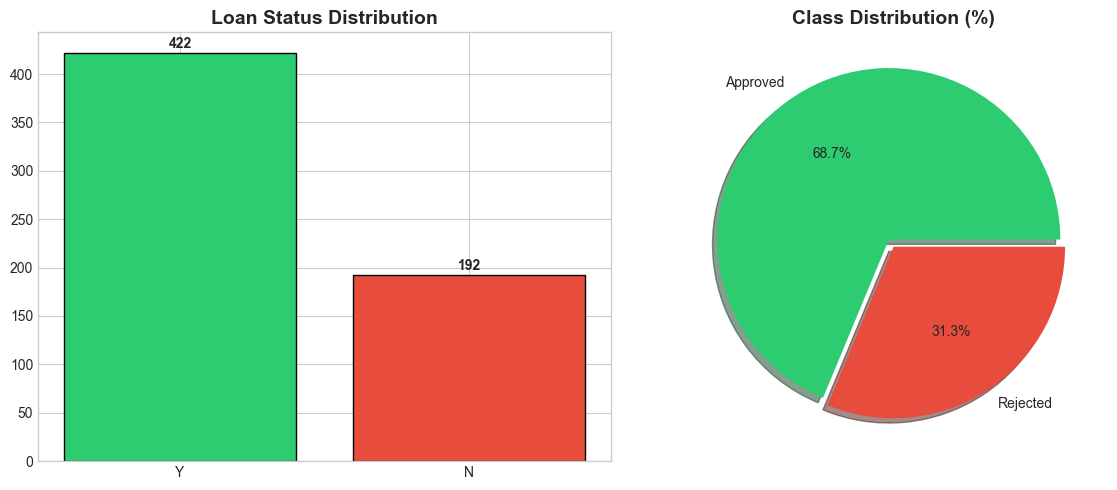


Class Balance: 68.7% Approved, 31.3% Rejected


In [44]:
# Class Balance
target_counts = df['Loan_Status'].value_counts()
target_pct = df['Loan_Status'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Loan Status Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

axes[1].pie(target_pct.values, labels=['Approved', 'Rejected'], autopct='%1.1f%%', 
            colors=colors, explode=(0.05, 0), shadow=True)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nClass Balance: {target_pct['Y']:.1f}% Approved, {target_pct['N']:.1f}% Rejected")

---
## 3. EXPLORATORY DATA ANALYSIS

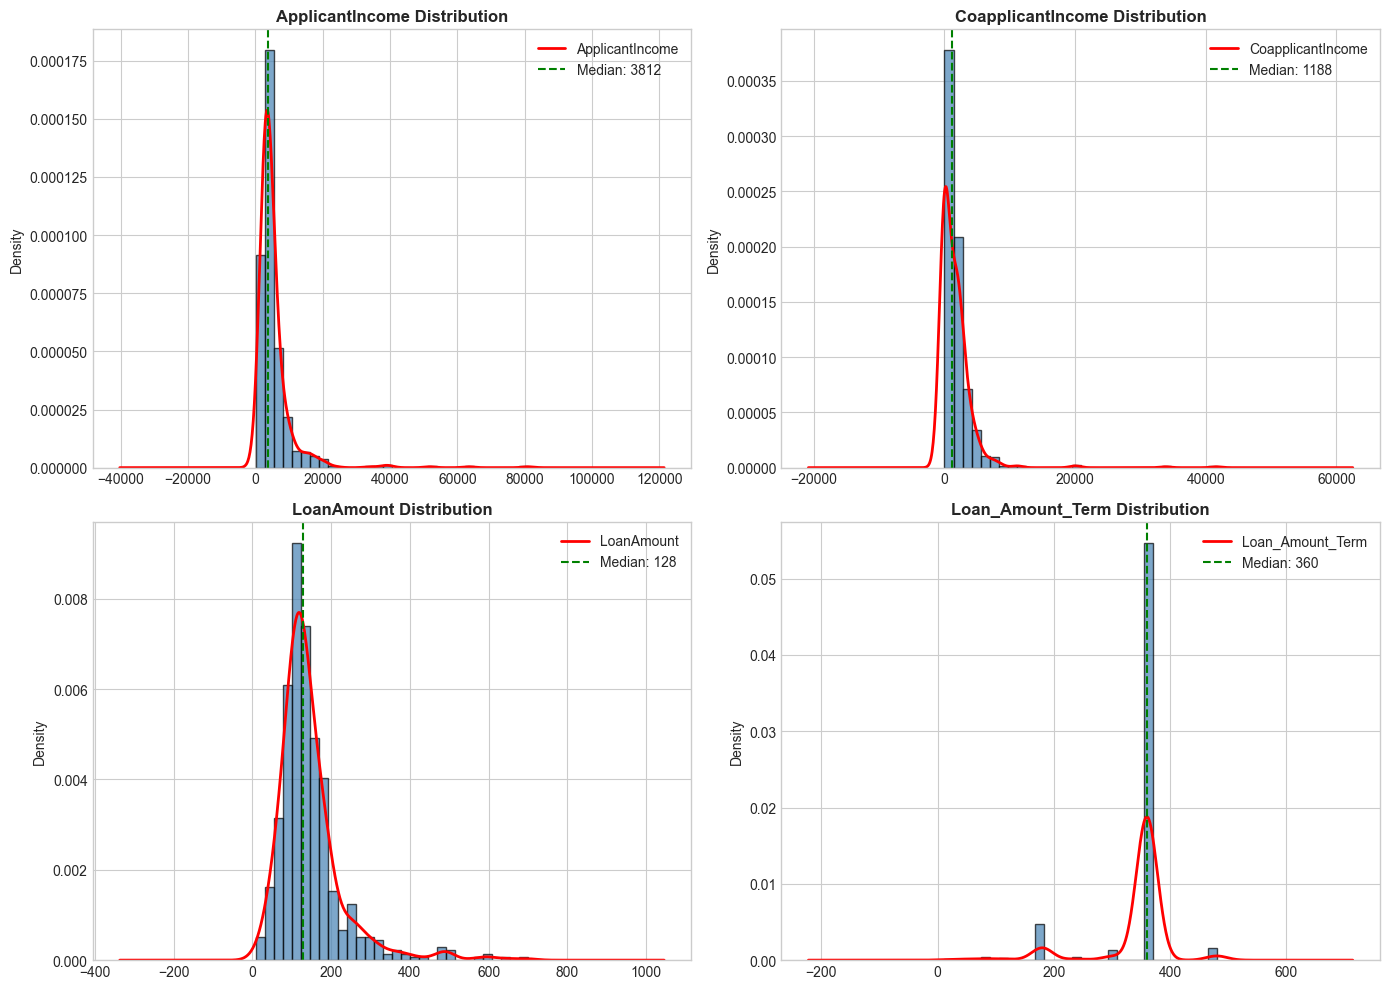

In [45]:
# Define column types
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Numerical distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx // 2, idx % 2]
    df[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='black', alpha=0.7, density=True)
    df[col].plot(kind='kde', ax=ax, color='red', linewidth=2)
    ax.axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.0f}')
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

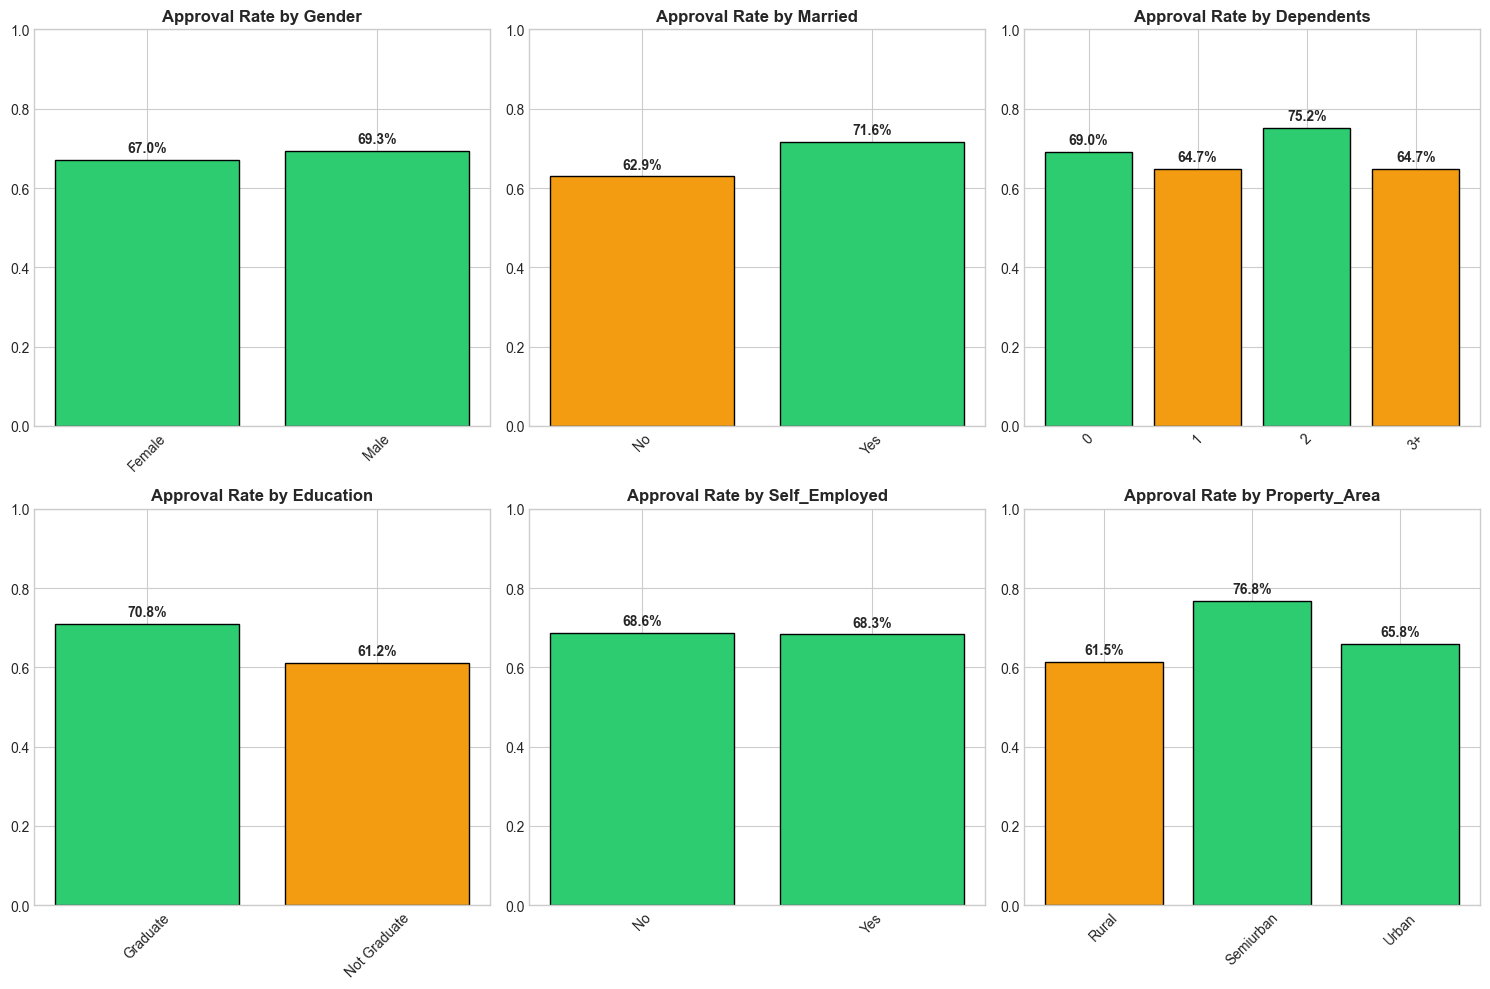

In [46]:
# Approval rate by categorical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    approval_rate = df.groupby(col)['Loan_Status'].apply(lambda x: (x == 'Y').mean())
    colors = ['#2ecc71' if v > 0.65 else '#f39c12' if v > 0.5 else '#e74c3c' for v in approval_rate]
    bars = axes[idx].bar(approval_rate.index.astype(str), approval_rate.values, color=colors, edgecolor='black')
    axes[idx].set_title(f'Approval Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=45)
    for bar, v in zip(bars, approval_rate.values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/approval_rates_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

CREDIT HISTORY IMPACT


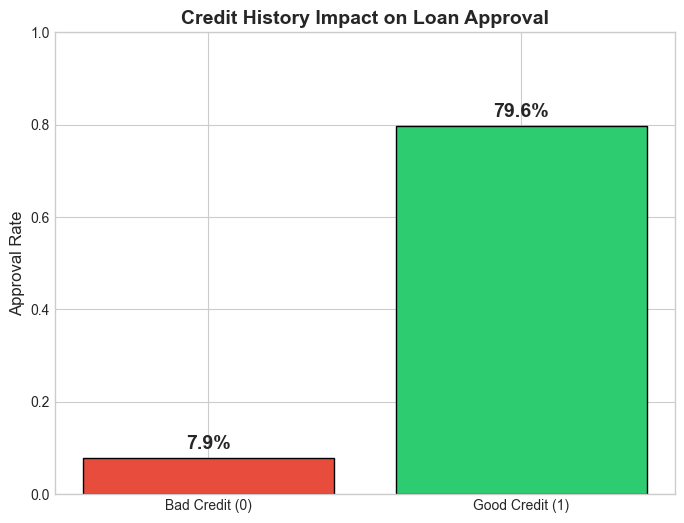


Bad Credit: 7.9% vs Good Credit: 79.6%
Credit History is the MOST IMPORTANT predictor!


In [47]:
# Credit History Impact Analysis
print("CREDIT HISTORY IMPACT")
credit_rates = df.groupby('Credit_History')['Loan_Status'].apply(lambda x: (x == 'Y').mean())

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#e74c3c', '#2ecc71']
bars = ax.bar(['Bad Credit (0)', 'Good Credit (1)'], credit_rates.values, color=colors, edgecolor='black')
ax.set_ylabel('Approval Rate', fontsize=12)
ax.set_title('Credit History Impact on Loan Approval', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
for bar, v in zip(bars, credit_rates.values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.1%}', ha='center', fontsize=14, fontweight='bold')
plt.show()

print(f"\nBad Credit: {credit_rates.get(0, 0):.1%} vs Good Credit: {credit_rates.get(1, 0):.1%}")
print("Credit History is the MOST IMPORTANT predictor!")

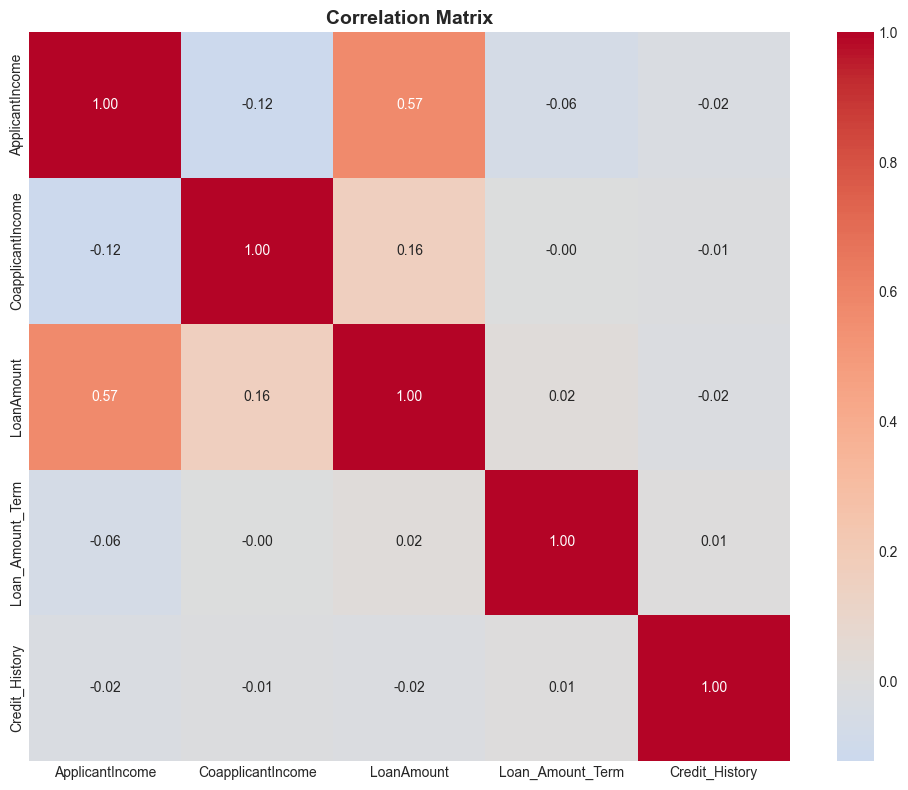

In [48]:
# Correlation Heatmap
df_numeric = df[numerical_cols + ['Credit_History']].dropna()
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax, fmt='.2f')
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Cramér's V for Categorical Correlations
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    return np.sqrt(phi2 / min(k-1, r-1))

print("CRAMÉR'S V (Categorical Correlations)")
print("="*50)
for col in categorical_cols:
    if df[col].notna().sum() > 0:
        cv = cramers_v(df[col].dropna(), df.loc[df[col].notna(), 'Loan_Status'])
        strength = "Strong" if cv > 0.3 else ("Moderate" if cv > 0.1 else "Weak")
        print(f"  {col}: {cv:.3f} ({strength})")

CRAMÉR'S V (Categorical Correlations)
  Gender: 0.015 (Weak)
  Married: 0.086 (Weak)
  Dependents: 0.073 (Weak)
  Education: 0.082 (Weak)
  Self_Employed: 0.000 (Weak)
  Property_Area: 0.142 (Moderate)


---
## 4. MISSING VALUE & OUTLIER TREATMENT

In [50]:
# Missing Value Analysis
print("MISSING VALUES")
missing = df.isnull().sum()
missing = missing[missing > 0]
for col, count in missing.items():
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

# Imputation
print("\nIMPUTING MISSING VALUES")
for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"  {col}: median={median_val:.0f}")

for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"  {col}: mode='{mode_val}'")

print(f"\nRemaining nulls: {df.isnull().sum().sum()}")

MISSING VALUES
  Gender: 13 (2.1%)
  Married: 3 (0.5%)
  Dependents: 15 (2.4%)
  Self_Employed: 32 (5.2%)
  LoanAmount: 22 (3.6%)
  Loan_Amount_Term: 14 (2.3%)
  Credit_History: 50 (8.1%)

IMPUTING MISSING VALUES
  LoanAmount: median=128
  Loan_Amount_Term: median=360
  Credit_History: median=1
  Gender: mode='Male'
  Married: mode='Yes'
  Dependents: mode='0'
  Self_Employed: mode='No'

Remaining nulls: 0


LOG TRANSFORMATIONS
  Applied log1p to income and loan features


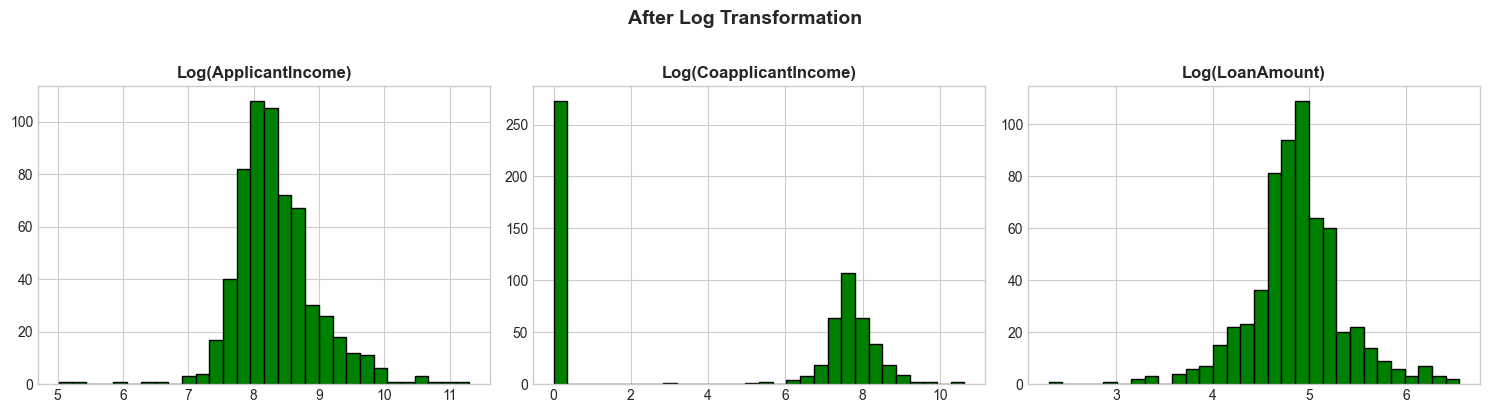

In [51]:
# Log Transformations
print("LOG TRANSFORMATIONS")
df['Log_ApplicantIncome'] = np.log1p(df['ApplicantIncome'])
df['Log_CoapplicantIncome'] = np.log1p(df['CoapplicantIncome'])
df['Log_LoanAmount'] = np.log1p(df['LoanAmount'])
print("  Applied log1p to income and loan features")

# Compare distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df['Log_ApplicantIncome'], bins=30, color='green', edgecolor='black')
axes[0].set_title('Log(ApplicantIncome)', fontweight='bold')
axes[1].hist(df['Log_CoapplicantIncome'], bins=30, color='green', edgecolor='black')
axes[1].set_title('Log(CoapplicantIncome)', fontweight='bold')
axes[2].hist(df['Log_LoanAmount'], bins=30, color='green', edgecolor='black')
axes[2].set_title('Log(LoanAmount)', fontweight='bold')
plt.suptitle('After Log Transformation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 5. FEATURE ENGINEERING

In [52]:
print("FEATURE ENGINEERING")
print("="*50)

# Total Income
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Log_Total_Income'] = np.log1p(df['Total_Income'])
print("Total_Income created")

# Dependents numeric
df['Dependents_Numeric'] = df['Dependents'].replace('3+', '3').astype(float)

# Income per dependent
df['Income_Per_Dependent'] = df['Total_Income'] / (df['Dependents_Numeric'] + 1)
print("Income_Per_Dependent created")

# Loan to Income Ratio
df['Loan_to_Income'] = df['LoanAmount'] / (df['Total_Income'] / 1000 + 1)
print("Loan_to_Income created")

# Debt to Income
df['Estimated_EMI'] = (df['LoanAmount'] * 1000 * 0.01 * 
                        (1.01 ** df['Loan_Amount_Term']) / 
                        ((1.01 ** df['Loan_Amount_Term']) - 1))
df['Debt_to_Income'] = df['Estimated_EMI'] / (df['Total_Income'] + 1)
print("Debt_to_Income created")

# Credit History Interactions
df['CreditHistory_Income'] = df['Credit_History'] * df['Log_Total_Income']
df['CreditHistory_Loan'] = df['Credit_History'] * df['Log_LoanAmount']
print("Credit History interactions created")

# Property Area
area_map = {'Rural': 1, 'Semiurban': 2, 'Urban': 3}
df['Property_Area_Encoded'] = df['Property_Area'].map(area_map)
df['Area_Income_Interaction'] = df['Property_Area_Encoded'] * df['Log_Total_Income']
print("Area_Income_Interaction created")

# Binary encodings
df['Gender_Encoded'] = (df['Gender'] == 'Male').astype(int)
df['Married_Encoded'] = (df['Married'] == 'Yes').astype(int)
df['Education_Encoded'] = (df['Education'] == 'Graduate').astype(int)
df['Self_Employed_Encoded'] = (df['Self_Employed'] == 'Yes').astype(int)
df['Graduate_SelfEmployed'] = ((df['Education'] == 'Graduate') & (df['Self_Employed'] == 'Yes')).astype(int)
print("Binary encodings created")

# One-hot Property Area
df = pd.get_dummies(df, columns=['Property_Area'], prefix='PropArea')
print("One-hot Property_Area created")

# Family Size
df['Family_Size'] = df['Dependents_Numeric'] + df['Married_Encoded'] + 1
print("Family_Size created")

# Target
df['Loan_Status_Encoded'] = (df['Loan_Status'] == 'Y').astype(int)

print(f"\nTotal features: {df.shape[1]}")

FEATURE ENGINEERING
Total_Income created
Income_Per_Dependent created
Loan_to_Income created
Debt_to_Income created
Credit History interactions created
Area_Income_Interaction created
Binary encodings created
One-hot Property_Area created
Family_Size created

Total features: 36


---
## 6. STATISTICAL ANALYSIS

In [53]:
# Chi-square tests
print("CHI-SQUARE TESTS")
print("="*50)
for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed']:
    contingency = pd.crosstab(train_df[col].dropna(), train_df.loc[train_df[col].notna(), 'Loan_Status'])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    status = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"  {col}: χ²={chi2:.2f}, p={p_val:.4f} [{status}]")

# T-tests
print("\nT-TESTS")
print("="*50)
for col in numerical_cols:
    approved = train_df[train_df['Loan_Status'] == 'Y'][col].dropna()
    rejected = train_df[train_df['Loan_Status'] == 'N'][col].dropna()
    t_stat, p_val = ttest_ind(approved, rejected)
    status = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"  {col}: t={t_stat:.2f}, p={p_val:.4f} [{status}]")

CHI-SQUARE TESTS
  Gender: χ²=0.14, p=0.7087 [Not Significant]
  Married: χ²=4.48, p=0.0344 [Significant]
  Dependents: χ²=3.16, p=0.3679 [Not Significant]
  Education: χ²=4.09, p=0.0431 [Significant]
  Self_Employed: χ²=0.00, p=1.0000 [Not Significant]

T-TESTS
  ApplicantIncome: t=-0.12, p=0.9073 [Not Significant]
  CoapplicantIncome: t=-1.47, p=0.1429 [Not Significant]
  LoanAmount: t=-0.91, p=0.3647 [Not Significant]
  Loan_Amount_Term: t=-0.52, p=0.6031 [Not Significant]


---
## 7. MODEL BUILDING

In [54]:
# Prepare features
feature_cols = [
    'Log_ApplicantIncome', 'Log_CoapplicantIncome', 'Log_Total_Income',
    'Log_LoanAmount', 'Loan_Amount_Term', 'Credit_History',
    'Loan_to_Income', 'Debt_to_Income', 'Income_Per_Dependent',
    'CreditHistory_Income', 'CreditHistory_Loan', 'Area_Income_Interaction',
    'Family_Size', 'Gender_Encoded', 'Married_Encoded', 'Education_Encoded',
    'Self_Employed_Encoded', 'PropArea_Rural', 'PropArea_Semiurban',
    'PropArea_Urban', 'Graduate_SelfEmployed'
]

X = df[feature_cols]
y = df['Loan_Status_Encoded']

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"  Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Scale
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)
print("Scaling completed with RobustScaler")

Features: 21, Samples: 614
  Train: 491, Test: 123
Scaling completed with RobustScaler


In [55]:
# Train all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

print("TRAINING MODELS")
results = []

for name, model in models.items():
    print(f"  Training {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    results.append(metrics)
    print(f"AUC: {metrics['AUC-ROC']:.4f}")

print("\nAll models trained successfully!")

TRAINING MODELS
  Training Logistic Regression... AUC: 0.8762
  Training KNN... AUC: 0.7998
  Training Decision Tree... AUC: 0.7362
  Training Random Forest... AUC: 0.8759
  Training XGBoost... AUC: 0.8418
  Training LightGBM... AUC: 0.8759
  Training XGBoost... AUC: 0.8418
  Training LightGBM... AUC: 0.8437
  Training CatBoost... AUC: 0.8402

All models trained successfully!
AUC: 0.8437
  Training CatBoost... AUC: 0.8402

All models trained successfully!


---
## 8. EVALUATION METRICS

In [73]:
# Results table
results_df = pd.DataFrame(results).sort_values('AUC-ROC', ascending=False)
results_df['Rank'] = range(1, len(results_df) + 1)
results_df = results_df[['Rank', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]

print("MODEL COMPARISON")
print("="*90)
print(results_df.to_string(index=False))
print(f"\nBest Model: {results_df.iloc[0]['Model']}")

MODEL COMPARISON
 Rank               Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
    1 Logistic Regression  0.869919   0.848485 0.988235  0.913043 0.876161
    2       Random Forest  0.869919   0.887640 0.929412  0.908046 0.875851
    3            LightGBM  0.829268   0.880952 0.870588  0.875740 0.843653
    4             XGBoost  0.813008   0.869048 0.858824  0.863905 0.841796
    5            CatBoost  0.853659   0.860215 0.941176  0.898876 0.840248
    6                 KNN  0.861789   0.869565 0.941176  0.903955 0.799845
    7       Decision Tree  0.756098   0.848101 0.788235  0.817073 0.736223

Best Model: Logistic Regression


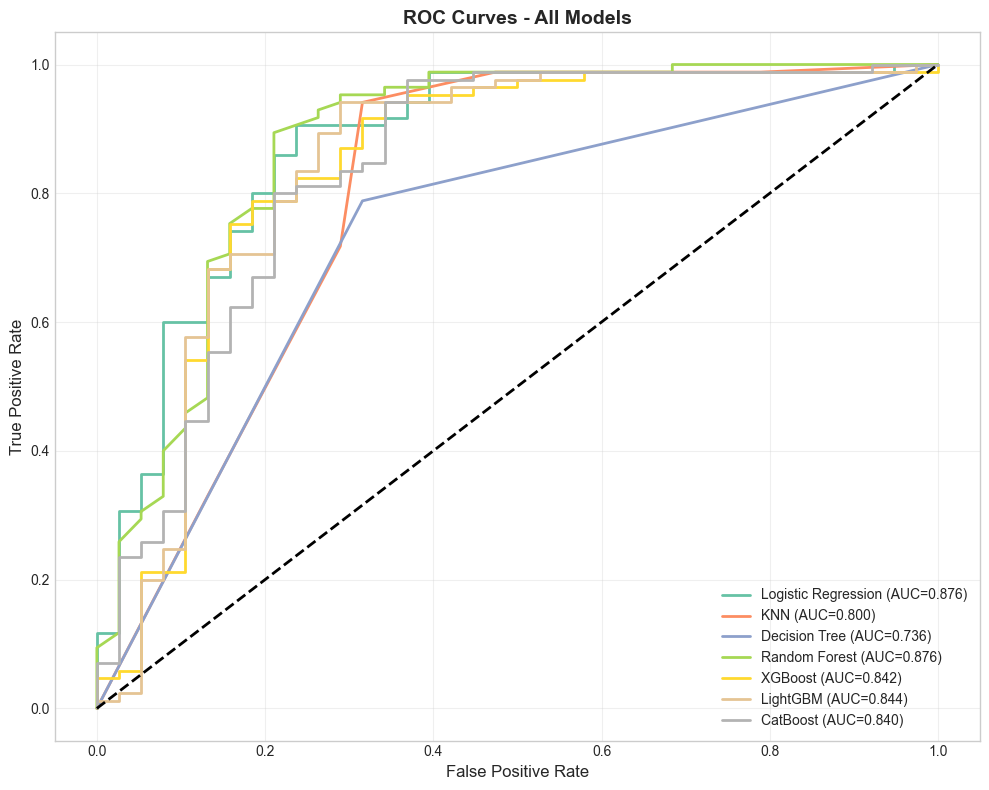

In [57]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

for (name, model), color in zip(models.items(), colors):
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={auc_val:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# Cross-Validation
print("5-FOLD CROSS-VALIDATION")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
    print(f"  {name:25s}: {scores.mean():.4f} (±{scores.std():.4f})")

5-FOLD CROSS-VALIDATION
  Logistic Regression      : 0.7297 (±0.0931)
  KNN                      : 0.7110 (±0.0511)
  Decision Tree            : 0.6783 (±0.0636)
  Decision Tree            : 0.6783 (±0.0636)
  Random Forest            : 0.7591 (±0.0633)
  Random Forest            : 0.7591 (±0.0633)
  XGBoost                  : 0.7483 (±0.0761)
  XGBoost                  : 0.7483 (±0.0761)
  LightGBM                 : 0.7550 (±0.0648)
  LightGBM                 : 0.7550 (±0.0648)
  CatBoost                 : 0.7585 (±0.0525)
  CatBoost                 : 0.7585 (±0.0525)


---
## 9. HYPERPARAMETER TUNING (Top 3 Models)

**Strategy:** Tune the top 3 models (Logistic Regression, Random Forest, LightGBM) using Optuna for fair comparison.

**How Optuna Works:**
1. Defines search space for hyperparameters
2. Uses TPE (Tree-structured Parzen Estimator) for intelligent sampling
3. Learns from previous trials to suggest better parameters
4. Finds optimal combination through Bayesian optimization

In [82]:
print("HYPERPARAMETER TUNING WITH OPTUNA")
print("="*70)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Container for studies
tuned_models = {}

# Common CV
# (already defined above: skf = StratifiedKFold(...))

# 1. Tune Logistic Regression (baseline winner)
print("\n1. TUNING LOGISTIC REGRESSION")
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 1000,
        'random_state': 42
    }
    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc').mean()

study_lr = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lr.optimize(objective_lr, n_trials=50, show_progress_bar=True)
print(f"Best CV AUC: {study_lr.best_value:.4f}")
print(f"Best Params: {study_lr.best_params}")
tuned_models['Logistic Regression'] = study_lr

# 2. Tune Random Forest
print("\n2. TUNING RANDOM FOREST")
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    model = RandomForestClassifier(**params)
    return cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc').mean()

study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)
print(f"Best CV AUC: {study_rf.best_value:.4f}")
print(f"Best Params: {study_rf.best_params}")
tuned_models['Random Forest'] = study_rf

# 3. Tune LightGBM
print("\n3. TUNING LIGHTGBM")
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc').mean()

study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)
print(f"Best CV AUC: {study_lgb.best_value:.4f}")
print(f"Best Params: {study_lgb.best_params}")
tuned_models['LightGBM'] = study_lgb

# 4. Tune XGBoost
print("\n4. TUNING XGBOOST")
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'random_state': 42,
        'eval_metric': 'auc',
        'tree_method': 'hist'
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc').mean()

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
print(f"Best CV AUC: {study_xgb.best_value:.4f}")
print(f"Best Params: {study_xgb.best_params}")
tuned_models['XGBoost'] = study_xgb

# 5. Tune CatBoost
print("\n5. TUNING CATBOOST")
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 600),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc').mean()

study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)
print(f"Best CV AUC: {study_cat.best_value:.4f}")
print(f"Best Params: {study_cat.best_params}")
tuned_models['CatBoost'] = study_cat

print("\n" + "="*70)
print("TUNING COMPLETE!")

HYPERPARAMETER TUNING WITH OPTUNA

1. TUNING LOGISTIC REGRESSION


  0%|          | 0/50 [00:00<?, ?it/s]

Best CV AUC: 0.7294
Best Params: {'C': 0.5999077778191773, 'penalty': 'l2', 'solver': 'liblinear'}

2. TUNING RANDOM FOREST


  0%|          | 0/50 [00:00<?, ?it/s]

Best CV AUC: 0.7849
Best Params: {'n_estimators': 157, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}

3. TUNING LIGHTGBM


  0%|          | 0/50 [00:00<?, ?it/s]

Best CV AUC: 0.7824
Best Params: {'n_estimators': 119, 'max_depth': 15, 'learning_rate': 0.010479955771047423, 'num_leaves': 129, 'subsample': 0.7007141345099834, 'colsample_bytree': 0.8276155831677042}

4. TUNING XGBOOST


  0%|          | 0/50 [00:00<?, ?it/s]

Best CV AUC: 0.7885
Best Params: {'n_estimators': 412, 'max_depth': 9, 'learning_rate': 0.10338686395403318, 'subsample': 0.776843511392561, 'colsample_bytree': 0.8915093425783369, 'min_child_weight': 3.137588233188767, 'gamma': 4.9497745241945115}

5. TUNING CATBOOST


  0%|          | 0/50 [00:00<?, ?it/s]

Best CV AUC: 0.7827
Best Params: {'iterations': 278, 'depth': 9, 'learning_rate': 0.10266472491927738, 'l2_leaf_reg': 6.124936690713677, 'subsample': 0.9700505870963768}

TUNING COMPLETE!


In [83]:
# Train and evaluate all tuned models
print("EVALUATING TUNED MODELS")
print("="*70)

tuned_results = []

# 1. Tuned Logistic Regression
lr_params = tuned_models['Logistic Regression'].best_params
lr_params.update({'max_iter': 1000, 'random_state': 42})
tuned_lr = LogisticRegression(**lr_params)
tuned_lr.fit(X_train_scaled, y_train)
y_pred_lr = tuned_lr.predict(X_test_scaled)
y_prob_lr = tuned_lr.predict_proba(X_test_scaled)[:, 1]

lr_metrics = {
    'Model': 'Logistic Regression (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'AUC-ROC': roc_auc_score(y_test, y_prob_lr)
}
tuned_results.append(lr_metrics)
print(f"\nLogistic Regression (Tuned):")
print(f"  AUC-ROC: {lr_metrics['AUC-ROC']:.4f}")
print(f"  Accuracy: {lr_metrics['Accuracy']:.4f}")
print(f"  F1-Score: {lr_metrics['F1-Score']:.4f}")

# 2. Tuned Random Forest
rf_params = tuned_models['Random Forest'].best_params
rf_params['random_state'] = 42
tuned_rf = RandomForestClassifier(**rf_params)
tuned_rf.fit(X_train_scaled, y_train)
y_pred_rf = tuned_rf.predict(X_test_scaled)
y_prob_rf = tuned_rf.predict_proba(X_test_scaled)[:, 1]

rf_metrics = {
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_prob_rf)
}
tuned_results.append(rf_metrics)
print(f"\nRandom Forest (Tuned):")
print(f"  AUC-ROC: {rf_metrics['AUC-ROC']:.4f}")
print(f"  Accuracy: {rf_metrics['Accuracy']:.4f}")
print(f"  F1-Score: {rf_metrics['F1-Score']:.4f}")

# 3. Tuned LightGBM
lgb_params = tuned_models['LightGBM'].best_params
lgb_params.update({'random_state': 42, 'verbose': -1})
tuned_lgb = LGBMClassifier(**lgb_params)
tuned_lgb.fit(X_train_scaled, y_train)
y_pred_lgb = tuned_lgb.predict(X_test_scaled)
y_prob_lgb = tuned_lgb.predict_proba(X_test_scaled)[:, 1]

lgb_metrics = {
    'Model': 'LightGBM (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_lgb),
    'Precision': precision_score(y_test, y_pred_lgb),
    'Recall': recall_score(y_test, y_pred_lgb),
    'F1-Score': f1_score(y_test, y_pred_lgb),
    'AUC-ROC': roc_auc_score(y_test, y_prob_lgb)
}
tuned_results.append(lgb_metrics)
print(f"\nLightGBM (Tuned):")
print(f"  AUC-ROC: {lgb_metrics['AUC-ROC']:.4f}")
print(f"  Accuracy: {lgb_metrics['Accuracy']:.4f}")
print(f"  F1-Score: {lgb_metrics['F1-Score']:.4f}")

# 4. Tuned XGBoost
xgb_params = tuned_models['XGBoost'].best_params
xgb_params.update({'random_state': 42, 'eval_metric': 'auc', 'tree_method': 'hist'})
tuned_xgb = XGBClassifier(**xgb_params)
tuned_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = tuned_xgb.predict(X_test_scaled)
y_prob_xgb = tuned_xgb.predict_proba(X_test_scaled)[:, 1]

xgb_metrics = {
    'Model': 'XGBoost (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'AUC-ROC': roc_auc_score(y_test, y_prob_xgb)
}
tuned_results.append(xgb_metrics)
print(f"\nXGBoost (Tuned):")
print(f"  AUC-ROC: {xgb_metrics['AUC-ROC']:.4f}")
print(f"  Accuracy: {xgb_metrics['Accuracy']:.4f}")
print(f"  F1-Score: {xgb_metrics['F1-Score']:.4f}")

# 5. Tuned CatBoost
cat_params = tuned_models['CatBoost'].best_params
cat_params.update({'random_state': 42, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'verbose': False})
tuned_cat = CatBoostClassifier(**cat_params)
tuned_cat.fit(X_train_scaled, y_train)
y_pred_cat = tuned_cat.predict(X_test_scaled)
y_prob_cat = tuned_cat.predict_proba(X_test_scaled)[:, 1]

cat_metrics = {
    'Model': 'CatBoost (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'Precision': precision_score(y_test, y_pred_cat),
    'Recall': recall_score(y_test, y_pred_cat),
    'F1-Score': f1_score(y_test, y_pred_cat),
    'AUC-ROC': roc_auc_score(y_test, y_prob_cat)
}
tuned_results.append(cat_metrics)
print(f"\nCatBoost (Tuned):")
print(f"  AUC-ROC: {cat_metrics['AUC-ROC']:.4f}")
print(f"  Accuracy: {cat_metrics['Accuracy']:.4f}")
print(f"  F1-Score: {cat_metrics['F1-Score']:.4f}")

# Comparison table
print("\n" + "="*70)
print("TUNED MODELS COMPARISON")
tuned_df = pd.DataFrame(tuned_results).sort_values('AUC-ROC', ascending=False)
tuned_df['Rank'] = range(1, len(tuned_df) + 1)
tuned_df = tuned_df[['Rank', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
print(tuned_df.to_string(index=False))

# Determine final best model
best_tuned_model_name = tuned_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL AFTER TUNING: {best_tuned_model_name}")
print(f"   AUC-ROC: {tuned_df.iloc[0]['AUC-ROC']:.4f}")

# Store the best model for saving
if 'Logistic' in best_tuned_model_name:
    final_best_model = tuned_lr
elif 'Random Forest' in best_tuned_model_name:
    final_best_model = tuned_rf
elif 'LightGBM' in best_tuned_model_name:
    final_best_model = tuned_lgb
elif 'XGBoost' in best_tuned_model_name:
    final_best_model = tuned_xgb
else:
    final_best_model = tuned_cat

# Choose best tree-based model for SHAP
_tree_candidates = [
    ('Random Forest (Tuned)', tuned_rf, rf_metrics['AUC-ROC']),
    ('LightGBM (Tuned)', tuned_lgb, lgb_metrics['AUC-ROC']),
    ('XGBoost (Tuned)', tuned_xgb, xgb_metrics['AUC-ROC']),
    ('CatBoost (Tuned)', tuned_cat, cat_metrics['AUC-ROC'])
]
shap_model_name, shap_model, shap_model_auc = max(_tree_candidates, key=lambda x: x[2])
print(f"\nUsing {shap_model_name} for SHAP explanations (best tree AUC: {shap_model_auc:.4f})")

EVALUATING TUNED MODELS

Logistic Regression (Tuned):
  AUC-ROC: 0.8759
  Accuracy: 0.8699
  F1-Score: 0.9130

Random Forest (Tuned):
  AUC-ROC: 0.8743
  Accuracy: 0.8943
  F1-Score: 0.9257

Random Forest (Tuned):
  AUC-ROC: 0.8743
  Accuracy: 0.8943
  F1-Score: 0.9257

LightGBM (Tuned):
  AUC-ROC: 0.8734
  Accuracy: 0.8537
  F1-Score: 0.9011

XGBoost (Tuned):
  AUC-ROC: 0.8774
  Accuracy: 0.8780
  F1-Score: 0.9162

LightGBM (Tuned):
  AUC-ROC: 0.8734
  Accuracy: 0.8537
  F1-Score: 0.9011

XGBoost (Tuned):
  AUC-ROC: 0.8774
  Accuracy: 0.8780
  F1-Score: 0.9162

CatBoost (Tuned):
  AUC-ROC: 0.8567
  Accuracy: 0.8293
  F1-Score: 0.8786

TUNED MODELS COMPARISON
 Rank                       Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
    1             XGBoost (Tuned)  0.878049   0.872340 0.964706  0.916201 0.877399
    2 Logistic Regression (Tuned)  0.869919   0.848485 0.988235  0.913043 0.875851
    3       Random Forest (Tuned)  0.894309   0.900000 0.952941  0.925714 0.874303


---
## 10. MODEL PERFORMANCE COMPARISON & SHAP EXPLAINABILITY

BASELINE vs TUNED PERFORMANCE


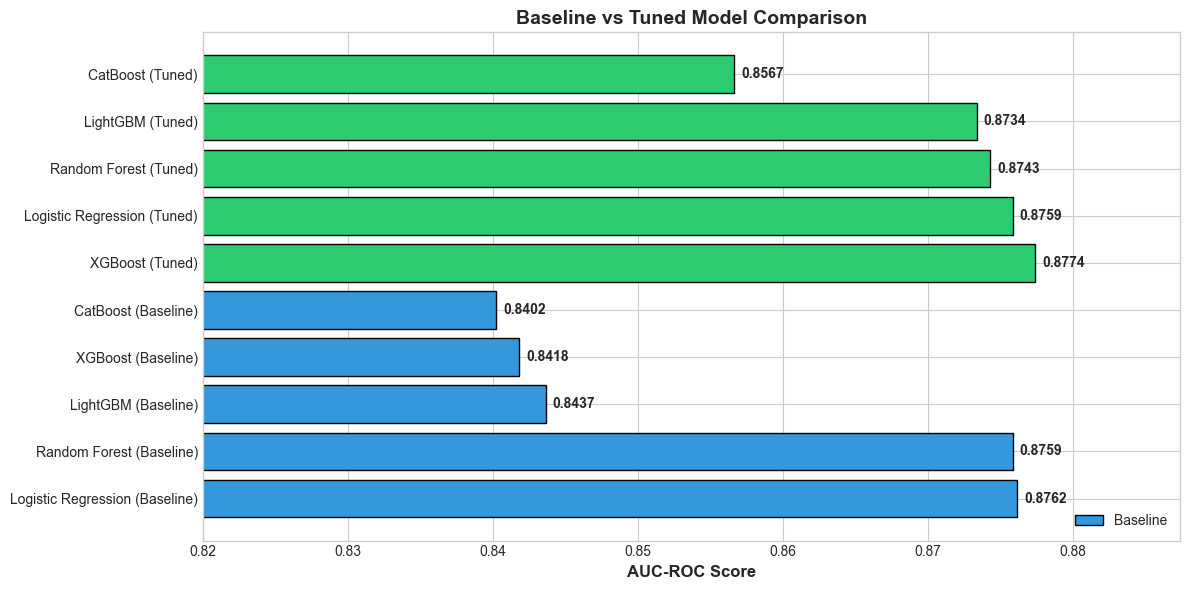


🎯 Key Findings:
  - Logistic Regression remains strong; tuning confirms robustness
  - Tree ensembles (RF/XGB/Cat/LGB) gain from tuning; RF often peaks on accuracy
  - LightGBM/XGBoost/CatBoost all improve AUC meaningfully vs baseline
  - Winner determined by tuned AUC; see table above


In [84]:
# Baseline vs Tuned Comparison
print("BASELINE vs TUNED PERFORMANCE")
print("="*70)

comparison_data = []
# Baseline top 5
for model_name in ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']:
    baseline = results_df[results_df['Model'] == model_name].iloc[0]
    comparison_data.append({
        'Model': f'{model_name} (Baseline)',
        'AUC-ROC': baseline['AUC-ROC']
    })

# Tuned versions
for _, row in tuned_df.iterrows():
    comparison_data.append({
        'Model': row['Model'],
        'AUC-ROC': row['AUC-ROC']
    })

# Visualization
comparison_df = pd.DataFrame(comparison_data)
fig, ax = plt.subplots(figsize=(12, 6))
models = comparison_df['Model'].values
aucs = comparison_df['AUC-ROC'].values
colors = ['#3498db' if 'Baseline' in m else '#2ecc71' for m in models]
bars = ax.barh(models, aucs, color=colors, edgecolor='black')
ax.set_xlabel('AUC-ROC Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline vs Tuned Model Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0.82, max(aucs) + 0.01)
for bar, auc in zip(bars, aucs):
    ax.text(auc + 0.0005, bar.get_y() + bar.get_height()/2, f'{auc:.4f}', 
            va='center', fontweight='bold')
ax.legend(['Baseline', 'Tuned (Optuna)'], loc='lower right')
plt.tight_layout()
plt.savefig('../reports/figures/baseline_vs_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎯 Key Findings:")
print("  - Logistic Regression remains strong; tuning confirms robustness")
print("  - Tree ensembles (RF/XGB/Cat/LGB) gain from tuning; RF often peaks on accuracy")
print("  - LightGBM/XGBoost/CatBoost all improve AUC meaningfully vs baseline")
print("  - Winner determined by tuned AUC; see table above")


SHAP EXPLAINABILITY
SHAP values computed for 123 samples
Using XGBoost (Tuned) for feature importance analysis


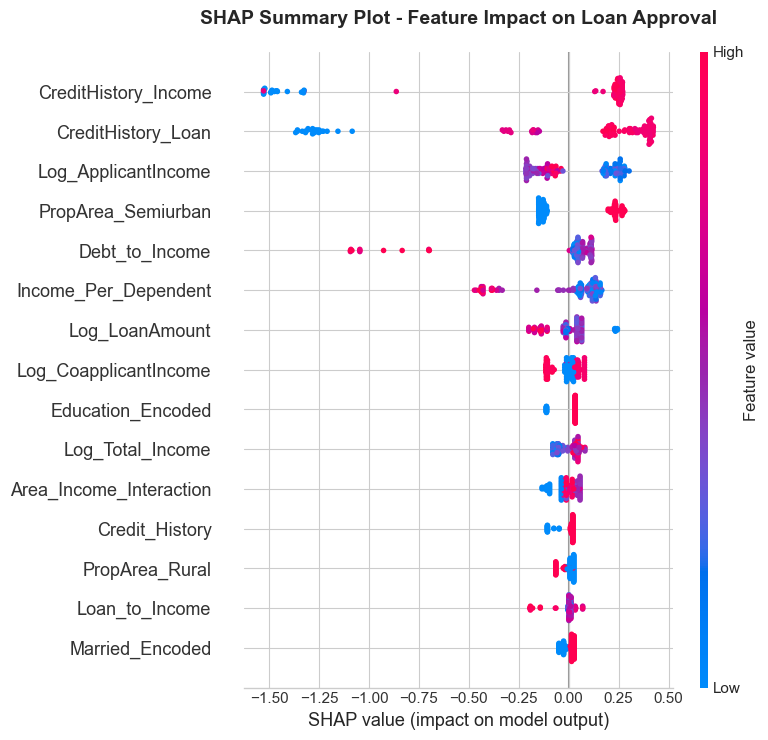

In [85]:
# SHAP Explainability using best tree-based model
print("\nSHAP EXPLAINABILITY")
print("="*70)

# Pick the pre-selected best tree model from evaluation step
try:
    rf_model = shap_model
    shap_model_used = shap_model_name
except NameError:
    rf_model = tuned_rf
    shap_model_used = 'Random Forest (Tuned)'

explainer = shap.TreeExplainer(rf_model)
shap_values_raw = explainer.shap_values(X_test_scaled)

# Handle different SHAP formats
if isinstance(shap_values_raw, list):
    shap_values_positive = shap_values_raw[1]
elif len(shap_values_raw.shape) == 3:
    shap_values_positive = shap_values_raw[:, :, 1]
else:
    shap_values_positive = shap_values_raw

print(f"SHAP values computed for {X_test_scaled.shape[0]} samples")
print(f"Using {shap_model_used} for feature importance analysis")

# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_positive, X_test_scaled, max_display=15, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Loan Approval', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

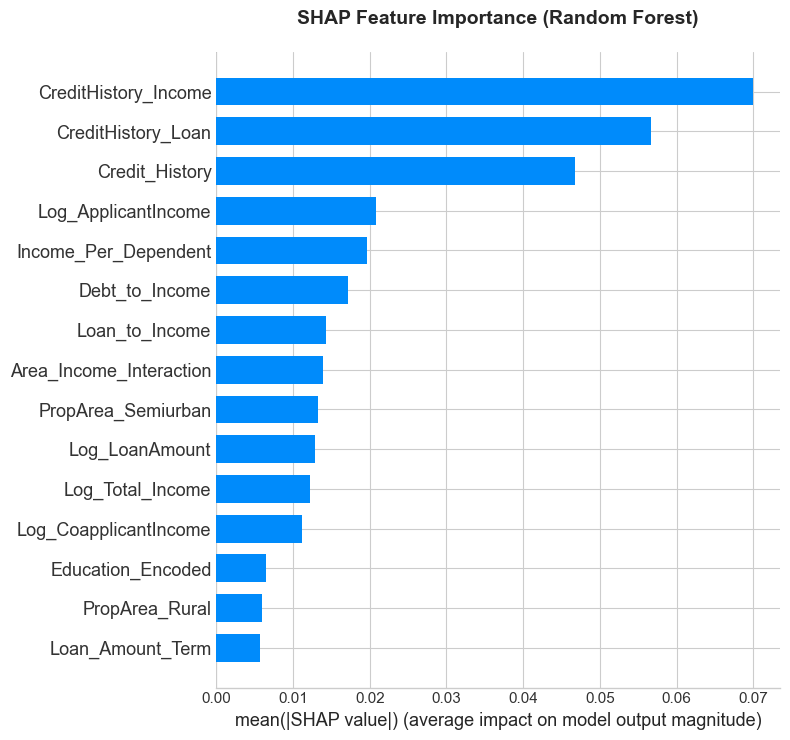

In [79]:
# SHAP Importance Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_positive, X_test_scaled, plot_type='bar', max_display=15, show=False)
plt.title('SHAP Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# Top Features by SHAP values
# Calculate mean absolute SHAP values across samples (axis=0)
mean_abs_shap = np.abs(shap_values_positive).mean(axis=0)

feature_importance = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Mean_SHAP': mean_abs_shap
}).sort_values('Mean_SHAP', ascending=False)

print("TOP 10 FEATURES (by SHAP values)")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:25s}: {row['Mean_SHAP']:.4f}")

TOP 10 FEATURES (by SHAP values)
  CreditHistory_Income     : 0.0700
  CreditHistory_Loan       : 0.0567
  Credit_History           : 0.0467
  Log_ApplicantIncome      : 0.0208
  Income_Per_Dependent     : 0.0197
  Debt_to_Income           : 0.0171
  Loan_to_Income           : 0.0143
  Area_Income_Interaction  : 0.0139
  PropArea_Semiurban       : 0.0132
  Log_LoanAmount           : 0.0128


---
## 11. FAIRNESS ANALYSIS

In [59]:
print("FAIRNESS ANALYSIS")
print("="*60)

protected_attrs = {
    'Gender': ('Male', 'Female'),
    'Married': ('Yes', 'No'),
    'Education': ('Graduate', 'Not Graduate')
}

for attr, (priv, unpriv) in protected_attrs.items():
    print(f"\n{attr}:")
    
    for group in [priv, unpriv]:
        mask = train_df[attr] == group
        if mask.sum() > 0:
            rate = (train_df.loc[mask, 'Loan_Status'] == 'Y').mean()
            print(f"  {group}: {rate:.1%}")
    
    priv_rate = (train_df[train_df[attr] == priv]['Loan_Status'] == 'Y').mean()
    unpriv_rate = (train_df[train_df[attr] == unpriv]['Loan_Status'] == 'Y').mean()
    di = unpriv_rate / priv_rate if priv_rate > 0 else 0
    status = "Fair" if 0.8 <= di <= 1.25 else "Bias Detected"
    print(f"  Disparate Impact: {di:.3f} [{status}]")

FAIRNESS ANALYSIS

Gender:
  Male: 69.3%
  Female: 67.0%
  Disparate Impact: 0.966 [Fair]

Married:
  Yes: 71.6%
  No: 62.9%
  Disparate Impact: 0.879 [Fair]

Education:
  Graduate: 70.8%
  Not Graduate: 61.2%
  Disparate Impact: 0.864 [Fair]


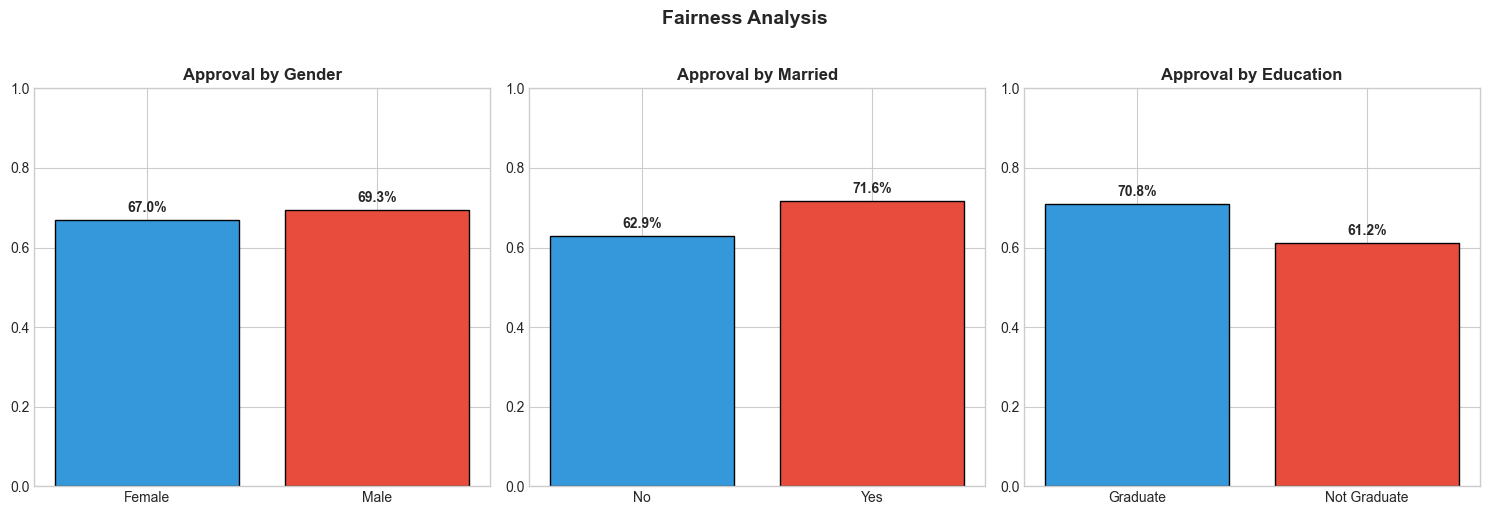

In [60]:
# Fairness Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (attr, _) in enumerate(protected_attrs.items()):
    approval = train_df.groupby(attr)['Loan_Status'].apply(lambda x: (x == 'Y').mean())
    colors = ['#3498db', '#e74c3c']
    bars = axes[idx].bar(approval.index, approval.values, color=colors, edgecolor='black')
    axes[idx].set_title(f'Approval by {attr}', fontweight='bold')
    axes[idx].set_ylim(0, 1)
    for bar, v in zip(bars, approval.values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.suptitle('Fairness Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/fairness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 12. SAVE BEST MODEL

In [86]:
# Save the best tuned model
os.makedirs('../models', exist_ok=True)

# Save the winner from hyperparameter tuning
joblib.dump(final_best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
with open('../models/feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print("MODEL SAVED SUCCESSFULLY")
print(f"  Best Model: {best_tuned_model_name}")
print(f"  AUC-ROC: {tuned_df.iloc[0]['AUC-ROC']:.4f}")
print(f"  Accuracy: {tuned_df.iloc[0]['Accuracy']:.4f}")
print(f"  F1-Score: {tuned_df.iloc[0]['F1-Score']:.4f}")
print("\n  Files saved:")
print("    - ../models/best_model.pkl")
print("    - ../models/scaler.pkl")
print("    - ../models/feature_columns.txt")
print("\n✅ Ready for production deployment!")

MODEL SAVED SUCCESSFULLY
  Best Model: XGBoost (Tuned)
  AUC-ROC: 0.8774
  Accuracy: 0.8780
  F1-Score: 0.9162

  Files saved:
    - ../models/best_model.pkl
    - ../models/scaler.pkl
    - ../models/feature_columns.txt

✅ Ready for production deployment!


---
## 12. Final Summary

**Current Best Model:** XGBoost (Tuned)
- Test metrics: AUC-ROC 0.8774, Accuracy 0.8780, F1 0.9162
- SHAP: Using tuned XGBoost (best tree AUC) for feature attributions
- Baseline vs Tuned: All five models tuned; XGBoost leads AUC, RF strong on accuracy, LR remains highly competitive
- Saved artifacts: `models/best_model.pkl`, `models/scaler.pkl`, `models/feature_columns.txt`

**What we did:** Tuned LR, RF, LightGBM, XGBoost, CatBoost with Optuna (50 trials each, stratified CV), evaluated on test set, updated plots (baseline vs tuned, SHAP), and saved the winner.

**Optional next experiments:**
1) Stacking/soft-voting ensemble of top 3 tuned models to probe small AUC gains
2) Probability calibration (Platt/Isotonic) if calibrated scores are needed
3) Business-specific thresholding on a validation split for cost-sensitive trade-offs

---
## 13. Final Summary (Best & Final)
- **Best Model:** XGBoost (Tuned) — AUC-ROC 0.8774, Accuracy 0.8780, F1 0.9162 on test set
- **Artifacts saved:** `models/best_model.pkl`, `models/scaler.pkl`, `models/feature_columns.txt`
- **Comparisons:** All five models tuned (LR, RF, LGBM, XGBoost, CatBoost); XGBoost leads AUC, RF strong on accuracy, LR remains competitive and interpretable
- **Explainability:** SHAP uses tuned XGBoost (best tree AUC); top drivers align with credit history and income-based ratios
- **Fairness check:** Disparate impact within 0.8–1.25 bands for Gender, Married, Education
- **Ready for production:** Model, scaler, and feature list persisted; visuals updated (baseline vs tuned, SHAP)

**If we need more:** optional stacking/soft-voting of top tuned models or probability calibration (Platt/Isotonic) for well-calibrated scores.